# Командная часть проекта

In [348]:
data_config = {
    'spindalis' : {
        'epigenetic_file' : 'epigenetic_genes.csv',
        'gff_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/946/903/255/GCA_946903255.1_tdSchSpin1.1b/GCA_946903255.1_tdSchSpin1.1b_genomic.gff.gz',
        'fna_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/946/903/255/GCA_946903255.1_tdSchSpin1.1b/GCA_946903255.1_tdSchSpin1.1b_genomic.fna.gz',
        'proteom_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/946/903/255/GCA_946903255.1_tdSchSpin1.1b/GCA_946903255.1_tdSchSpin1.1b_protein.faa.gz'
    },
    'japonicum' : {
        'epigenetic_file' : 'epigenetic_genes.csv',
        'gff_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/021/461/655/GCA_021461655.1_ASM2146165v1/GCA_021461655.1_ASM2146165v1_genomic.gff.gz',
        'fna_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/021/461/655/GCA_021461655.1_ASM2146165v1/GCA_021461655.1_ASM2146165v1_genomic.fna.gz',
        'proteom_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/021/461/655/GCA_021461655.1_ASM2146165v1/GCA_021461655.1_ASM2146165v1_protein.faa.gz'
    },
    'bovis' : {
    },
    'mattheei' : {
        'epigenetic_file' : 'epigenetic_genes.csv',
        'gff_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/944/470/405/GCA_944470405.2_tdSchMatt1.2/GCA_944470405.2_tdSchMatt1.2_genomic.gff.gz',
        'fna_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/944/470/405/GCA_944470405.2_tdSchMatt1.2/GCA_944470405.2_tdSchMatt1.2_genomic.fna.gz',
        'proteom_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/944/470/405/GCA_944470405.2_tdSchMatt1.2/GCA_944470405.2_tdSchMatt1.2_protein.faa.gz'
    },
    'haematobium' : {
        'gff_url' : 'https://ftp.ebi.ac.uk/pub/databases/wormbase/parasite/releases/WBPS19/species/schistosoma_haematobium/PRJNA78265/schistosoma_haematobium.PRJNA78265.WBPS19.annotations.gff3.gz',
        'fna_url' : 'https://ftp.ebi.ac.uk/pub/databases/wormbase/parasite/releases/WBPS19/species/schistosoma_haematobium/PRJNA78265/schistosoma_haematobium.PRJNA78265.WBPS19.genomic.fa.gz',
        'proteom_url' : 'https://ftp.ebi.ac.uk/pub/databases/wormbase/parasite/releases/WBPS19/species/schistosoma_haematobium/PRJNA78265/schistosoma_haematobium.PRJNA78265.WBPS19.protein.fa.gz'
    },
    'mansoni' : {
        'gff_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/237/925/GCF_000237925.1_ASM23792v2/GCF_000237925.1_ASM23792v2_genomic.gff.gz',
        'fna_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/237/925/GCF_000237925.1_ASM23792v2/GCF_000237925.1_ASM23792v2_genomic.fna.gz',
        'proteom_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/237/925/GCF_000237925.1_ASM23792v2/GCF_000237925.1_ASM23792v2_protein.faa.gz'
    },
    'intercalatum': {
        'epigenetic_file' : 'epigenetic_genes.csv',
        'g4_file' : 'g4_segments.csv',
        'zdna_file' : 'zdna_segments.csv',
        'gff_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/944/470/385/GCA_944470385.2_tdSchInte2.2/GCA_944470385.2_tdSchInte2.2_genomic.gff.gz',
        'fna_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/944/470/385/GCA_944470385.2_tdSchInte2.2/GCA_944470385.2_tdSchInte2.2_genomic.fna.gz',
        'proteom_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/944/470/385/GCA_944470385.2_tdSchInte2.2/GCA_944470385.2_tdSchInte2.2_protein.faa.gz'
    },
    'mekongi' : {
        'epigenetic_file' : 'epigenetic_genes.csv',
        'gff_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/034/768/735/GCA_034768735.1_ASM3476873v1/GCA_034768735.1_ASM3476873v1_genomic.gff.gz',
        'fna_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/034/768/735/GCA_034768735.1_ASM3476873v1/GCA_034768735.1_ASM3476873v1_genomic.fna.gz',
        'proteom_url' : 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/034/768/735/GCA_034768735.1_ASM3476873v1/GCA_034768735.1_ASM3476873v1_protein.faa.gz'
    },
}

In [351]:
# скачаем аннотации

# скачивание файлов генома и аннотации

import requests
import logging
import pathlib
import glob
import os
import sys
import itertools

logging.basicConfig(level=logging.INFO, force = True)

def download_file(url: str, local_file_name: pathlib.Path):
    if pathlib.Path(local_file_name).is_file():
        logging.info(f'file {local_file_name} already exists')
        return local_file_name
    logging.info(f'downloading {local_file_name}')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_file_name, 'wb') as out_file:
            for chunk in r.iter_content(chunk_size=8192): 
                out_file.write(chunk)

    return local_file_name

gff_files = dict()
fna_files = dict()
proteom_files = dict()

# скачиваем аннотации
for current_organism, current_data_config in data_config.items():
    if 'gff_url' in current_data_config:
        gff_files[current_organism] = download_file(current_data_config['gff_url'], f'data/{current_data_config['gff_url'].split('/')[-1]}')
    else:
        logging.warning(f'No gff url provided for {current_organism}')
    
    if 'fna_url' in current_data_config:
        fna_files[current_organism] = download_file(current_data_config['fna_url'], f'data/{current_data_config['fna_url'].split('/')[-1]}')
    else:
        logging.warning(f'No fna url provided for {current_organism}')

    if 'proteom_url' in current_data_config:
        proteom_files[current_organism] = download_file(current_data_config['proteom_url'], f'data/{current_data_config['proteom_url'].split('/')[-1]}')
    else:
        logging.warning(f'No proteom url provided for {current_organism}')

print(file=sys.stderr)

# распакуем сжатые файлы для удобства
for organism, filepath in itertools.chain(gff_files.items(), fna_files.items(), proteom_files.items()):
    current_file_path = pathlib.Path(filepath)
    assert current_file_path.is_file()
    if current_file_path.suffix == '.gz':
        current_extracted_file = current_file_path.parent / pathlib.Path(filepath).stem
        if current_extracted_file.is_file():
            logging.info(f'{current_extracted_file} already exists')
        else:
            logging.info(f'extracting {current_extracted_file}')
            os.system(f'gunzip -k {current_extracted_file}')

for organism, filepath in gff_files.items():
    if pathlib.Path(filepath).suffix == '.gz':
        gff_files[organism] = current_file_path.parent / pathlib.Path(filepath).stem

for organism, filepath in fna_files.items():
    if pathlib.Path(filepath).suffix == '.gz':
        fna_files[organism] = current_file_path.parent / pathlib.Path(filepath).stem

for organism, filepath in proteom_files.items():
    if pathlib.Path(filepath).suffix == '.gz':
        proteom_files[organism] = current_file_path.parent / pathlib.Path(filepath).stem


INFO:root:file data/GCA_946903255.1_tdSchSpin1.1b_genomic.gff.gz already exists
INFO:root:file data/GCA_946903255.1_tdSchSpin1.1b_genomic.fna.gz already exists
INFO:root:file data/GCA_946903255.1_tdSchSpin1.1b_protein.faa.gz already exists
INFO:root:file data/GCA_021461655.1_ASM2146165v1_genomic.gff.gz already exists
INFO:root:file data/GCA_021461655.1_ASM2146165v1_genomic.fna.gz already exists
INFO:root:file data/GCA_021461655.1_ASM2146165v1_protein.faa.gz already exists
INFO:root:file data/GCA_944470405.2_tdSchMatt1.2_genomic.gff.gz already exists
INFO:root:file data/GCA_944470405.2_tdSchMatt1.2_genomic.fna.gz already exists
INFO:root:file data/GCA_944470405.2_tdSchMatt1.2_protein.faa.gz already exists
INFO:root:file data/schistosoma_haematobium.PRJNA78265.WBPS19.annotations.gff3.gz already exists
INFO:root:file data/schistosoma_haematobium.PRJNA78265.WBPS19.genomic.fa.gz already exists
INFO:root:file data/schistosoma_haematobium.PRJNA78265.WBPS19.protein.fa.gz already exists
INFO:ro

In [328]:
# функции для чтения данных из результатов индивидуальных проектов

import pandas as pd
import pathlib

def get_epigenetic_genes(organism: str):
    assert organism in data_config, f'unknown organism: {organism}'

    if 'epigenetic_file' in data_config[organism]:
        file_name = data_config[organism]['epigenetic_file']
        if pathlib.Path(file_name).suffix == '.csv':
            res = pd.read_csv(f'data_in/{organism}/{data_config[organism]['epigenetic_file']}')
            res = res[['Family', 'Gene_ID']]
            res.columns = ['family', 'gene']
            return res
        else:
            assert False, "Please, add support for your file type" # TODO
    else:
        logging.warning(f'No epigenetic_file specified for {organism}')
        return None

def get_g4(organism: str):
    assert organism in data_config, f'unknown organism: {organism}'

    if 'g4_file' in data_config[organism]:
        file_name = data_config[organism]['g4_file']
        if pathlib.Path(file_name).suffix == '.csv':
            res = pd.read_csv(f'data_in/{organism}/{data_config[organism]['g4_file']}')
            return res
        else:
            assert False, "Please, add support for your file type" # TODO

    else:
        logging.warning(f'No epigenetic_file specified for {organism}')
        return None

def get_zdna(organism: str):
    assert organism in data_config, f'unknown organism: {organism}'

    if 'zdna_file' in data_config[organism]:
        file_name = data_config[organism]['zdna_file']
        if pathlib.Path(file_name).suffix == '.csv':
            res = pd.read_csv(f'data_in/{organism}/{data_config[organism]['zdna_file']}')
            return res
        else:
            assert None, "Please, add support for your file type" # TODO

    else:
        logging.warning(f'No epigenetic_file specified for {organism}')
        return None

# need_contain one of 'g4' or 'zdna'
def get_genes_with_promoters_contains(organism: str, need_contain: str):
    assert organism in data_config, f'unknown organism: {organism}'
    assert need_contain in ['g4', 'zdna']

    segments = get_g4(organism) if need_contain == 'g4' else get_zdna(organism)
    if segments is None:
        return None

    if organism in gff_files:
        res = []
        with open(gff_files[organism]) as gff_file:
            for row in gff_file:
                if row[0] != '#':
                    row_splitted = row.strip().split()
                    if row_splitted[2] == 'gene':
                        gene_coords = (int(row_splitted[3]), int(row_splitted[4]))
                        promoter_coords = (gene_coords[0] - 1000, gene_coords[0] - 1)
                        if row_splitted[5] == '-':
                            promoter_coords = (gene_coords[1] + 1, gene_coords[1] + 1000)

                        # поиск квадруплексов или zdna
                        found_segments = []
                        for _, segment_row in segments.iterrows():
                            if segment_row['record_id'] == row_splitted[0]:
                                cur_interval = (segment_row['start'], segment_row['end'])
                                if pd.Interval(*cur_interval, closed='both').overlaps(pd.Interval(*promoter_coords, closed='both')):
                                    found_segments.append(cur_interval)
                        
                        if len(found_segments) != 0:
                            gene_id = row_splitted[8].split('ID=')[1].split(';')[0]
                            res.append([row_splitted[0], gene_id, promoter_coords[0], promoter_coords[1], found_segments])
        res = pd.DataFrame(res)
        res.columns = ['record_id', 'gene', 'start', 'end', 'matches']
        return res
    else:
        logging.warning(f'No gff specified for {organism}')
        return None



In [329]:
# установка меги

# https://drive.google.com/file/d/1beRdRYvyRw38orLmFiXE-p2paAILFvVm/view?usp=sharing


mega_file_id = "1beRdRYvyRw38orLmFiXE-p2paAILFvVm"
mega_url = f"https://drive.google.com/uc?export=download&id={mega_file_id}"

# скачивание меги

import requests
import pandas as pd
import pathlib
import logging

mega_gz = pathlib.Path('local_programs/mega.tar.gz')
mega_dir = pathlib.Path('local_programs/mega')

if mega_gz.is_file():
    logging.info(f'{mega_gz} already exists')
else:
    logging.info(f'downloading {mega_gz}')
    response = requests.get(mega_url)
    assert response.status_code == 200, 'Wrong status code'
    with open(mega_gz, 'wb') as out_file:
        out_file.write(response.content)

if not mega_dir.is_dir():
    logging.info(f'extracting {mega_gz}')
    ! cd local_programs/ && mkdir -p mega && tar -xzf mega.tar.gz -C mega
else:
    logging.info(f'already exists')

INFO:root:local_programs/mega.tar.gz already exists
INFO:root:already exists


### 1. От каждого организма в группе Выбрать из генов отвечающих за эпигенетику 4-5 (как минимум 1 на члена группы) и построить для них выравнивания и деревья.

In [330]:
# выбираем гены для выравнивания

import logging

family_in_organisms = dict()
epigenetic_genes_for_alignment = []

for organism in data_config:
    current_epigenetic_genes = get_epigenetic_genes(organism)
    if current_epigenetic_genes is not None:
        logging.info(f'Adding genes for {organism}')
        
        current_epigenetic_genes['organism'] = organism
        epigenetic_genes_for_alignment.append(current_epigenetic_genes)

        for _, row in current_epigenetic_genes.iterrows():
            if row['family'] not in family_in_organisms:
                family_in_organisms[row['family']] = set()
            family_in_organisms[row['family']].add(organism)
    else:
        logging.warning(f'current_epigenetic_genes({organism}) is None')

family_in_organisms_array = []
for family, organisms in family_in_organisms.items():
    family_in_organisms_array.append((family, len(organisms)))

family_in_organisms_array = list(sorted(family_in_organisms_array, key=lambda x : -x[1]))
family_in_organisms_array = family_in_organisms_array[:8]

selected_families = [x[0] for x in family_in_organisms_array]

epigenetic_genes_for_alignment = pd.concat(epigenetic_genes_for_alignment)
epigenetic_genes_for_alignment = epigenetic_genes_for_alignment[epigenetic_genes_for_alignment['family'].apply(lambda x : x in selected_families)]
epigenetic_genes_for_alignment.sort_values('family', inplace=True)
epigenetic_genes_for_alignment.drop_duplicates(subset=['family', 'organism'], keep='first', inplace=True)
epigenetic_genes_for_alignment.reset_index(inplace=True, drop=True)
epigenetic_genes_for_alignment.drop_duplicates()

INFO:root:Adding genes for spindalis
INFO:root:Adding genes for japonicum
INFO:root:Adding genes for mattheei
INFO:root:Adding genes for intercalatum
INFO:root:Adding genes for mekongi


,family,gene,organism
0,ACINU,gene-SSPN1_LOCUS6014,spindalis
1,ACINU,gene-SMTH1_LOCUS6929,mattheei
2,ACINU,gene-KSF78_0008119,japonicum
3,ACINU,gene-SINT2_LOCUS6163,intercalatum
4,ACINU,gene-MN116_008246,mekongi
5,AEBP2,gene-MN116_001510,mekongi
6,AEBP2,gene-SMTH1_LOCUS10615,mattheei
7,AEBP2,gene-SSPN1_LOCUS9217,spindalis
8,AEBP2,gene-KSF78_0005440,japonicum
9,AEBP2,gene-SINT2_LOCUS8012,intercalatum


In [331]:
# Добавим в табличку хромосому координаты каждого

import logging

gene_organism_to_position = dict()

for _, row in epigenetic_genes_for_alignment.iterrows():
    gene_organism_to_position[(row['organism'], row['gene'])] = None

for organism in data_config:
    if organism in gff_files:
        with open(gff_files[organism], 'r') as gff_file:
            for row in gff_file:
                current_row = row.strip()
                if len(current_row) == 0 or current_row[0] == '#':
                    continue
                current_row_splitted = row.split()

                if current_row_splitted[2] == 'gene':
                    current_gene_id = current_row_splitted[8].split('ID=')[1].split(';')[0]
                    if (organism, current_gene_id) in gene_organism_to_position:
                        gene_organism_to_position[(organism, current_gene_id)] = (current_row_splitted[0], int(current_row_splitted[3]), int(current_row_splitted[4]))
    else:
        logging.warning(f'No such gff file for {organism}')

def get_position(row):
    res = gene_organism_to_position[(row['organism'], row['gene'])]
    return res

epigenetic_genes_for_alignment[['record_id', 'start', 'end']] = \
    epigenetic_genes_for_alignment.apply(get_position, axis=1, result_type='expand')

epigenetic_genes_for_alignment

,family,gene,organism,record_id,start,end
0,ACINU,gene-SSPN1_LOCUS6014,spindalis,OX336419.1,20174797,20192511
1,ACINU,gene-SMTH1_LOCUS6929,mattheei,OX103946.1,19000643,19025157
2,ACINU,gene-KSF78_0008119,japonicum,CM038286.1,12019241,12028457
3,ACINU,gene-SINT2_LOCUS6163,intercalatum,OX103880.1,17878940,17899255
4,ACINU,gene-MN116_008246,mekongi,CM068311.1,9544071,9569391
5,AEBP2,gene-MN116_001510,mekongi,CM068305.1,41392895,41398756
6,AEBP2,gene-SMTH1_LOCUS10615,mattheei,OX103943.1,85876995,85881366
7,AEBP2,gene-SSPN1_LOCUS9217,spindalis,OX336416.1,86989145,86991956
8,AEBP2,gene-KSF78_0005440,japonicum,CM038283.1,42441718,42464061
9,AEBP2,gene-SINT2_LOCUS8012,intercalatum,OX103883.1,28294149,28315298


In [332]:
# Добавим в табличку последовательность гена

import pandas as pd
import logging
from Bio import SeqIO

record_to_position = dict()

for _, row in epigenetic_genes_for_alignment.iterrows():
    if row['record_id'] not in record_to_position:
        record_to_position[row['record_id']] = dict()
    record_to_position[row['record_id']][(row['start'], row['end'])] = None

record_to_position

for organism in data_config:
    if organism in fna_files:
        records = list(SeqIO.parse(fna_files[organism], "fasta"))
        for record in records:
            if record.id in record_to_position:
                for requested_range in record_to_position[record.id]:
                    record_to_position[record.id][requested_range] = record.seq[requested_range[0]-1:requested_range[1]]

    else:
        logging.warning(f'No such fna file for {organism}')

def get_sequence(row):
    return [record_to_position[row['record_id']][(row['start'], row['end'])]]
        
epigenetic_genes_for_alignment[['data']] = \
    epigenetic_genes_for_alignment.apply(get_sequence, axis=1, result_type='expand')

epigenetic_genes_for_alignment['data'] = epigenetic_genes_for_alignment['data'].apply(lambda s : str(s).lower())
epigenetic_genes_for_alignment

,family,gene,organism,record_id,start,end,data
0,ACINU,gene-SSPN1_LOCUS6014,spindalis,OX336419.1,20174797,20192511,atgtctactccggagggtgttctgttgccagatggccggagaattg...
1,ACINU,gene-SMTH1_LOCUS6929,mattheei,OX103946.1,19000643,19025157,tcaacgtcgtgatcgataacgatttgatgaggaacgatctctacgt...
2,ACINU,gene-KSF78_0008119,japonicum,CM038286.1,12019241,12028457,gcatttgaatcaagtcaccgcggatagtttaagaatagcttattta...
3,ACINU,gene-SINT2_LOCUS6163,intercalatum,OX103880.1,17878940,17899255,ttaacgtcgtgatcgataacgatttgatgaggaacgatctctacgt...
4,ACINU,gene-MN116_008246,mekongi,CM068311.1,9544071,9569391,atgtctactccagaggacgttattttacctgatggtcgtagaattg...
5,AEBP2,gene-MN116_001510,mekongi,CM068305.1,41392895,41398756,atgaatcgcacaagttctccgttggatgaagcatatgggacataca...
6,AEBP2,gene-SMTH1_LOCUS10615,mattheei,OX103943.1,85876995,85881366,gttcaccatttctagtcatgtttgggagatgaaaacctgtttatct...
7,AEBP2,gene-SSPN1_LOCUS9217,spindalis,OX336416.1,86989145,86991956,atgagtatattattcaatccatcattttttgatatacacttctttt...
8,AEBP2,gene-KSF78_0005440,japonicum,CM038283.1,42441718,42464061,aatttatttggctgattcatcggattgtgtccttctattacgatct...
9,AEBP2,gene-SINT2_LOCUS8012,intercalatum,OX103883.1,28294149,28315298,atgtcttctgggatagaggtgattgagtctggtttccatgttactc...


In [333]:
import os
import logging

# настройки меги для выравнивания
with open("data/muscle_align.mao", "w") as f:
    f.write("""; Please do not edit this file! If this file is modified, results are unpredictable.
; Instead of modifying this file, simply create a new MEGA Analysis Options file by using the MEGA Prototyper.
[ DataSettings ]
datatype                 = snNucleotide            
containsCodingNuc        = False                   
missingBaseSymbol        = ?                       
identicalBaseSymbol      = .                       
gapSymbol                = -                       
[ ProcessTypes ]
ppAlign                  = true                    
ppClustalW               = true                    
[ AnalysisSettings ]
Pairwise Alignment       = ====================    
DNAPWGapOpeningPenalty   = 15.00                   
DNAPWGapExtensionPenalty = 6.66                    
Multiple Alignment       = ====================    
DNAMAGapOpeningPenalty   = 15.00                   
DNAMAGapExtensionPenalty = 6.66                    
Global Options           = ====================    
DNA Weight Matrix        = IUB                     
TransitionWeightNEdit    = 0.50                    
UseNegativeMatrix        = ON                      
DelayDivergentCutoff     = 30                      
KeepPredefinedGaps       = True""")

epigenetec_alignment_results = []

for family, subdf in epigenetic_genes_for_alignment.groupby('family'):
    # запишем последовательности в fasta файл
    current_fasta_file = f'data/epigenetic_genes_for_alignment_{family}.fasta'
    current_meg_file = f'data/epigenetic_genes_alignment_{family}.meg'
    with open(current_fasta_file, 'w') as fasta_file:
        for _, row in subdf.iterrows():
            seq_id, seq = f'{row['organism']}:{row['gene']}', row['data']
            fasta_file.write(f">{seq_id}\n{seq}\n")
    # запуск меги
    logging.info(f'Running allignment for {family}')
    os.system(f'./local_programs/mega/megacc -a data/muscle_align.mao -d {current_fasta_file} -o {current_meg_file} > /dev/null 2>&1')
    epigenetec_alignment_results.append((family, current_meg_file))
    logging.info(f'Allignment for {family} done')

INFO:root:Running allignment for ACINU
INFO:root:Allignment for ACINU done
INFO:root:Running allignment for AEBP2
INFO:root:Allignment for AEBP2 done
INFO:root:Running allignment for ARID1A
INFO:root:Allignment for ARID1A done
INFO:root:Running allignment for ATR
INFO:root:Allignment for ATR done
INFO:root:Running allignment for ATRX
INFO:root:Allignment for ATRX done
INFO:root:Running allignment for BAP1
INFO:root:Allignment for BAP1 done
INFO:root:Running allignment for BARD1
INFO:root:Allignment for BARD1 done
INFO:root:Running allignment for BPTF
INFO:root:Allignment for BPTF done


In [ ]:
import os

# настройки меги для построения дерева
with open("data/nj_tree.mao", "w") as f:
    f.write("""[ DataSettings ]
datatype                             = snNucleotide                        
containsCodingNuc                    = True                                
MissingBaseSymbol                    = ?                                   
IdenticalBaseSymbol                  = .                                   
GapSymbol                            = -                                   
[ ProcessTypes ]
ppInfer                              = true                                
ppML                                 = true                                
[ AnalysisSettings ]
Analysis                             = Phylogeny Reconstruction            
Statistical Method                   = Maximum Likelihood                  
Phylogeny Test                       = ====================                
Test of Phylogeny                    = Bootstrap method                    
No. of Bootstrap Replications        = 500                                 
Substitution Model                   = ====================                
Substitutions Type                   = Nucleotide                          
Model/Method                         = Kimura 2-parameter model            
Rates and Patterns                   = ====================                
Rates among Sites                    = Uniform Rates                       
No of Discrete Gamma Categories      = Not Applicable                      
Data Subset to Use                   = ====================                
Gaps/Missing Data Treatment          = Complete deletion                   
Site Coverage Cutoff (%)             = Not Applicable                      
Select Codon Positions               = 1st, 2nd, 3rd, Non-Coding           
Tree Inference Options               = ====================                
ML Heuristic Method                  = Nearest-Neighbor-Interchange (NNI)  
Initial Tree for ML                  = Make initial tree automatically (Neighbor Joining)
Branch Swap Filter                   = Strong                              
System Resource Usage                = ====================                
Number of Threads                    = 1                                   
Genetic Code Table                   = Not Applicable                      
Genetic Code                         = Not Applicable                      
Has Time Limit                       = False                               
Maximum Execution Time               = -1  """)

epigenetec_trees_results = []

# запуск меги
for family, current_alignment_file in epigenetec_alignment_results:
    current_nwk_file = f'data/epigenetic_genes_tree_{family}.nwk'
    logging.info(f'Running tree building for {family}')
    os.system(f'./local_programs/mega/megacc -a data/nj_tree.mao -d {current_alignment_file} -o {current_nwk_file} > /dev/null 2>&1')
    epigenetec_trees_results.append((family, current_nwk_file))
    logging.info(f'Tree building for {family} done')

INFO:root:Running tree building for ACINU
INFO:root:Tree building for ACINU done
INFO:root:Running tree building for AEBP2
INFO:root:Tree building for AEBP2 done
INFO:root:Running tree building for ARID1A
INFO:root:Tree building for ARID1A done
INFO:root:Running tree building for ATR
INFO:root:Tree building for ATR done
INFO:root:Running tree building for ATRX
INFO:root:Tree building for ATRX done
INFO:root:Running tree building for BAP1
INFO:root:Tree building for BAP1 done
INFO:root:Running tree building for BARD1
INFO:root:Tree building for BARD1 done
INFO:root:Running tree building for BPTF
INFO:root:Tree building for BPTF done



                 FigTree v1.4.4, 2006-2018
                  Tree Figure Drawing Tool
                       Andrew Rambaut

             Institute of Evolutionary Biology
                  University of Edinburgh
                     a.rambaut@ed.ac.uk

                 http://tree.bio.ed.ac.uk/
    Uses the Java Evolutionary Biology 2 Library (JEBL2)
                http://jebl2.googlecode.com/
                 Uses the iText PDF Library
                    http://itextpdf.com/
               Uses the Apache Batik Library
            http://xmlgraphics.apache.org/batik/
                 Uses the JDOM XML Library
                    http://www.jdom.org/
 Thanks to Alexei Drummond, Joseph Heled, Philippe Lemey, 
Tulio de Oliveira, Oliver Pybus, Beth Shapiro & Marc Suchard

Creating SVG graphic: data/epigenetic_genes_tree_ACINU.svg


'ACINU:'

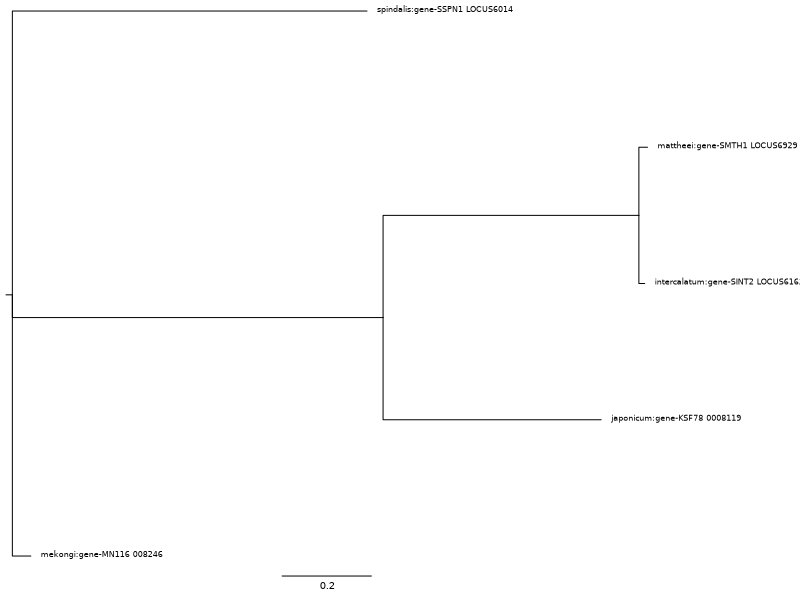


                 FigTree v1.4.4, 2006-2018
                  Tree Figure Drawing Tool
                       Andrew Rambaut

             Institute of Evolutionary Biology
                  University of Edinburgh
                     a.rambaut@ed.ac.uk

                 http://tree.bio.ed.ac.uk/
    Uses the Java Evolutionary Biology 2 Library (JEBL2)
                http://jebl2.googlecode.com/
                 Uses the iText PDF Library
                    http://itextpdf.com/
               Uses the Apache Batik Library
            http://xmlgraphics.apache.org/batik/
                 Uses the JDOM XML Library
                    http://www.jdom.org/
 Thanks to Alexei Drummond, Joseph Heled, Philippe Lemey, 
Tulio de Oliveira, Oliver Pybus, Beth Shapiro & Marc Suchard

Creating SVG graphic: data/epigenetic_genes_tree_AEBP2.svg


'AEBP2:'

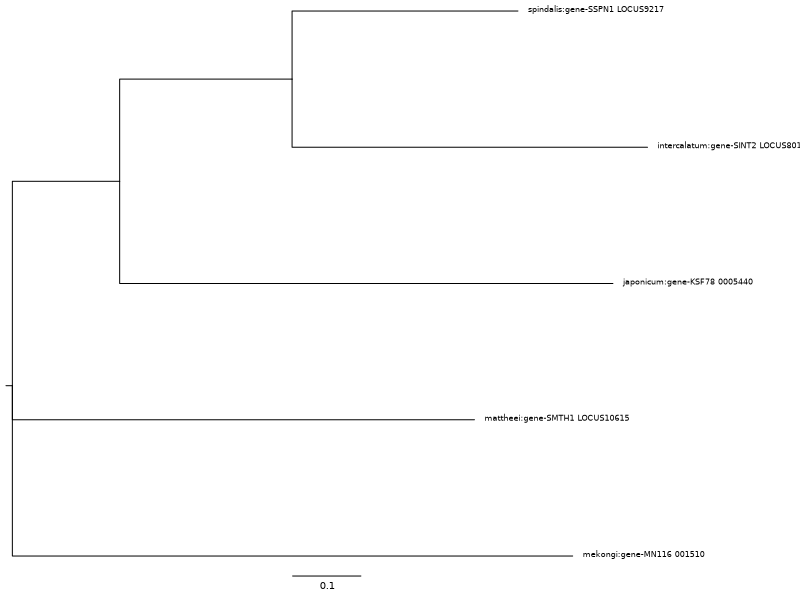


                 FigTree v1.4.4, 2006-2018
                  Tree Figure Drawing Tool
                       Andrew Rambaut

             Institute of Evolutionary Biology
                  University of Edinburgh
                     a.rambaut@ed.ac.uk

                 http://tree.bio.ed.ac.uk/
    Uses the Java Evolutionary Biology 2 Library (JEBL2)
                http://jebl2.googlecode.com/
                 Uses the iText PDF Library
                    http://itextpdf.com/
               Uses the Apache Batik Library
            http://xmlgraphics.apache.org/batik/
                 Uses the JDOM XML Library
                    http://www.jdom.org/
 Thanks to Alexei Drummond, Joseph Heled, Philippe Lemey, 
Tulio de Oliveira, Oliver Pybus, Beth Shapiro & Marc Suchard

Creating SVG graphic: data/epigenetic_genes_tree_ARID1A.svg


'ARID1A:'

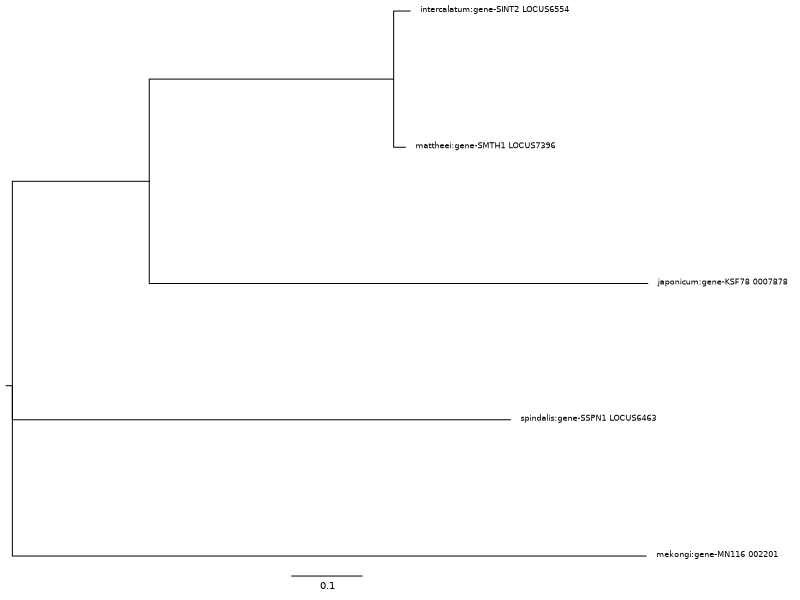


                 FigTree v1.4.4, 2006-2018
                  Tree Figure Drawing Tool
                       Andrew Rambaut

             Institute of Evolutionary Biology
                  University of Edinburgh
                     a.rambaut@ed.ac.uk

                 http://tree.bio.ed.ac.uk/
    Uses the Java Evolutionary Biology 2 Library (JEBL2)
                http://jebl2.googlecode.com/
                 Uses the iText PDF Library
                    http://itextpdf.com/
               Uses the Apache Batik Library
            http://xmlgraphics.apache.org/batik/
                 Uses the JDOM XML Library
                    http://www.jdom.org/
 Thanks to Alexei Drummond, Joseph Heled, Philippe Lemey, 
Tulio de Oliveira, Oliver Pybus, Beth Shapiro & Marc Suchard



Exception in thread "main" java.lang.RuntimeException: Error writing graphic file: data/epigenetic_genes_tree_ATR.nwk (No such file or directory)
	at figtree.application.FigTreeApplication.createGraphic(Unknown Source)
	at figtree.application.FigTreeApplication.main(Unknown Source)


'ATR:'

FileNotFoundError: [Errno 2] No such file or directory: 'data/epigenetic_genes_tree_ATR.svg'

In [335]:
# картинки деревьев
from IPython.display import SVG, display
import os

for family, epigenetec_trees_result in epigenetec_trees_results:
    current_image_file = f'data/epigenetic_genes_tree_{family}.svg'
    os.system(f'figtree -graphic SVG {epigenetec_trees_result} {current_image_file}')
    display(f'{family}:')
    display(SVG(filename=current_image_file))

# более красивые картинки в отчете (тоже figtree, только через gui с настройками)

### 2 и 3: Ищем ортологи

In [347]:
# установка orthofinder

import logging
import pathlib

if pathlib.Path('local_programs/OrthoFinder_source.tar.gz').is_file():
    logging.info('local_programs/OrthoFinder_source.tar.gz alreasy exists')
else:
    logging.info('Downloading OrthoFinder_source.tar.gz')
    ! cd local_programs/ && wget https://github.com/davidemms/OrthoFinder/releases/download/3.0.1b1/OrthoFinder_source.tar.gz

if pathlib.Path('local_programs/OrthoFinder_source').is_dir():
    logging.info('local_programs/OrthoFinder_source alreasy exists')
else:
    logging.info('Extracting OrthoFinder_source.tar.gz')
    ! cd local_programs/ && tar -xzf OrthoFinder_source.tar.gz

! python local_programs/OrthoFinder_source/orthofinder.py -h

INFO:root:local_programs/OrthoFinder_source.tar.gz alreasy exists
INFO:root:local_programs/OrthoFinder_source alreasy exists



OrthoFinder version 3.0.1b1 Copyright (C) 2014 David Emms

SIMPLE USAGE:
Run full OrthoFinder analysis on FASTA format proteomes in <dir>
  orthofinder [options] -f <dir>

To assign species from <dir1> to existing OrthoFinder orthogroups in <dir2>
  orthofinder [options] --assign <dir1> --core <dir2>

OPTIONS:
 -t <int>        Number of parallel sequence search threads [Default = 12]
 -a <int>        Number of parallel analysis threads
 -d              Input is DNA sequences
 -M <txt>        Method for gene tree inference. Options 'dendroblast' & 'msa'
                 [Default = msa]
 -S <txt>        Sequence search program [Default = diamond]
                 Options: blast, diamond, diamond_ultra_sens, blast_gz, mmseqs, blast_nucl
 -A <txt>        MSA program, requires '-M msa' [Default = mafft]
                 Options: mafft, muscle, mafft_memsave
 -T <txt>        Tree inference method, requires '-M msa' [Default = fasttree]
                 Options: fasttree, fasttree_fastest, r

In [ ]:
# готовим файлы для поиска ортологов

import os

! mkdir -p data/proteom
for organism, proteom_file in proteom_files.items():
    os.system(f'cp {proteom_file} data/proteom/{organism}.faa')

### 2. От каждого организма в группе выбрать 4-5 (как минимум 1 на члена группы)  генов (ортологов) в промоторах которых есть  квадруплексы и для этих квадруплексов построить выравнивание. И указать где есть вариации (в петле, числе повторов, выпетливания и т.п.) Если таких генов меньше, то для всех генов, что нашлись.

In [248]:
organism_to_genes_with_g4_in_promoter = dict()

for organism in data_config:
    res = get_genes_with_promoters_contains(organism, 'g4')
    if res is None:
        continue
    res['organism'] = organism
    organism_to_genes_with_g4_in_promoter[organism] = res

In [245]:
organism_to_genes_with_g4_in_promoter

{}